<a href="https://colab.research.google.com/github/GiX7000/object-detection/blob/main/Scocco_Detector_with_RetinaNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scocco Detection

This notebook uses the TensorFlow Object Detection API and retrains [RetinaNet](https://arxiv.org/abs/1708.02002) to spot my dog, scocco,by using just 5 training images. 


# 1. Environment Setup

Installation of Tensorflow 2 [Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection). Import all necessary libraries and create some helper utilities.

In [1]:
# clone the Tensorflow Model Garden
!git clone --depth 1 https://github.com/tensorflow/models/

# install the Object Detection API
!cd models/research/ && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install .

Cloning into 'models'...
remote: Enumerating objects: 2603, done.
remote: Counting objects: 100% (2603/2603), done.
remote: Compressing objects: 100% (2163/2163), done.
remote: Total 2603 (delta 649), reused 1217 (delta 407), pack-reused 0
Receiving objects: 100% (2603/2603), 32.56 MiB | 23.56 MiB/s, done.
Resolving deltas: 100% (649/649), done.
Processing /content/models/research
     |████████████████████████████████| 9.0MB 5.7MB/s 
     |████████████████████████████████| 358kB 42.3MB/s 
     |████████████████████████████████| 1.1MB 50.6MB/s 
     |████████████████████████████████| 17.7MB 146kB/s 
     |████████████████████████████████| 153kB 54.5MB/s 
     |████████████████████████████████| 61kB 5.1MB/s 
     |████████████████████████████████| 829kB 51.5MB/s 
     |████████████████████████████████| 2.3MB 44.4MB/s 
     |████████████████████████████████| 61kB 7.2MB/s 
     |████████████████████████████████| 174kB 57.2MB/s 
     |████████████████████████████████| 37.6MB 150kB/s 
     

In [2]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import zipfile
import io
import scipy.misc
import numpy as np

import glob
import imageio
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

# import the label map utility module
from object_detection.utils import label_map_util

# import module for reading and updating configuration files.
from object_detection.utils import config_util

# import module for visualization. use the alias `viz_utils`
from object_detection.utils  import visualization_utils as viz_utils

# import module for building the detection model
from object_detection.builders import model_builder

# import module for utilities in Colab
from object_detection.utils import colab_utils

In [3]:
# utility functions for loading images and plotting detections

def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
    path: a file path.

    Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
    """
    
    img_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(img_data))
    (im_width, im_height) = image.size
    
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)


def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
    """Wrapper function to visualize detections.

    Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
          and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
          this function assumes that the boxes to be plotted are groundtruth
          boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
          category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
    """
    
    image_np_with_annotations = image_np.copy()
    
    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_annotations,
        boxes,
        classes,
        scores,
        category_index,
        use_normalized_coordinates=True,
        min_score_thresh=0.8)
    
    if image_name:
        plt.imsave(image_name, image_np_with_annotations)
    
    else:
        plt.imshow(image_np_with_annotations)


# 2. Data Preparation

Download train and test sets, create ground truth boxes for training data, preprocess them and define category index dictionary for our training job.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# get the dataset from drive
%cd drive/MyDrive/
!cp -r scocco_training /content/
!cp -r scocco_testing /content/

/content/drive/MyDrive


/content
./scocco_training/training-scocco1.jpg
./scocco_training/training-scocco2.jpg
./scocco_training/training-scocco3.jpg
./scocco_training/training-scocco4.jpg
./scocco_training/training-scocco5.jpg


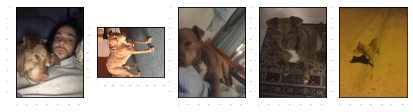

In [6]:
# visualize training images
%cd /content/
%matplotlib inline

# assign the name (string) of the directory containing the training images
train_image_dir = './scocco_training'

# declare an empty list
train_images_np = []

# run a for loop for each image
for i in range(1, 6):

    # define the path (string) for each image
    image_path = os.path.join(train_image_dir, 'training-scocco' + str(i) + '.jpg')
    print(image_path)

    # load images into numpy arrays and append to a list
    train_images_np.append(load_image_into_numpy_array(image_path))
### END CODE HERE ###

# configure plot settings via rcParams
plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [7, 7]

# plot images
for idx, train_image_np in enumerate(train_images_np):
    plt.subplot(1, 5, idx+1)
    plt.imshow(train_image_np)

plt.show()

In [7]:
# create ground truth boxes for training images

# Define the list of ground truth boxes
gt_boxes = []

# annotate the training images
colab_utils.annotate(train_images_np, box_storage_pointer=gt_boxes)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

In [9]:
# draw the above ground truth boxes
try:
  assert(len(gt_boxes) == 5), "Warning: gt_boxes is empty. Did you click `submit`?"

except AssertionError as e:
  print(e)

# checks if there are boxes for all 5 images
for gt_box in gt_boxes:
    try:
      assert(gt_box is not None), "There are less than 5 sets of box coordinates. " \
                                  "Please re-run the cell above to draw the boxes again.\n" \
                                  "Alternatively, you can run the next cell to load pre-determined " \
                                  "ground truth boxes."
    
    except AssertionError as e:
        print(e)
        break

# print the coordinates ground truth boxes
for gt_box in gt_boxes:
  print(gt_box)

[[0.2912     0.         0.86286667 0.4984375 ]]
[[0.11286667 0.13887897 0.98953334 0.52958334]]
[[0.24286667 0.         0.9162     0.8109375 ]]
[[0.10453334 0.125      0.7962     0.9375    ]]
[[0.34453334 0.2125     0.69286667 0.6140625 ]]


In [10]:
# define what classes our model recognizes: only one, scocco

# scocco's class ID
scocco_class_id = 1

# define a dictionary describing the scocco class
category_index = {scocco_class_id: {
    "id": scocco_class_id,
    "name": "Scocco"
}}

# number of classes that the model will predict
num_classes = 1

print(category_index[scocco_class_id])

{'id': 1, 'name': 'Scocco'}


In [11]:
# some data preprocessing: convert class labels to 1-hot representation and convert everything to tensors

# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.

label_id_offset = 1
train_image_tensors = []

# lists containing the one-hot encoded classes and ground truth boxes
gt_classes_one_hot_tensors = []
gt_box_tensors = []

for (train_image_np, gt_box_np) in zip(train_images_np, gt_boxes):
    
    # convert training image to tensor, add batch dimension, and add to list
    train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
        train_image_np, dtype=tf.float32), axis=0))
    
    # convert numpy array to tensor, then add to list
    gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
    
    # apply offset to to have zero-indexed ground truth classes
    zero_indexed_groundtruth_classes = tf.convert_to_tensor(
        np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
    
    # do one-hot encoding to ground truth classes
    gt_classes_one_hot_tensors.append(tf.one_hot(
        zero_indexed_groundtruth_classes, num_classes))

print('Done preparing data.')

Done preparing data.


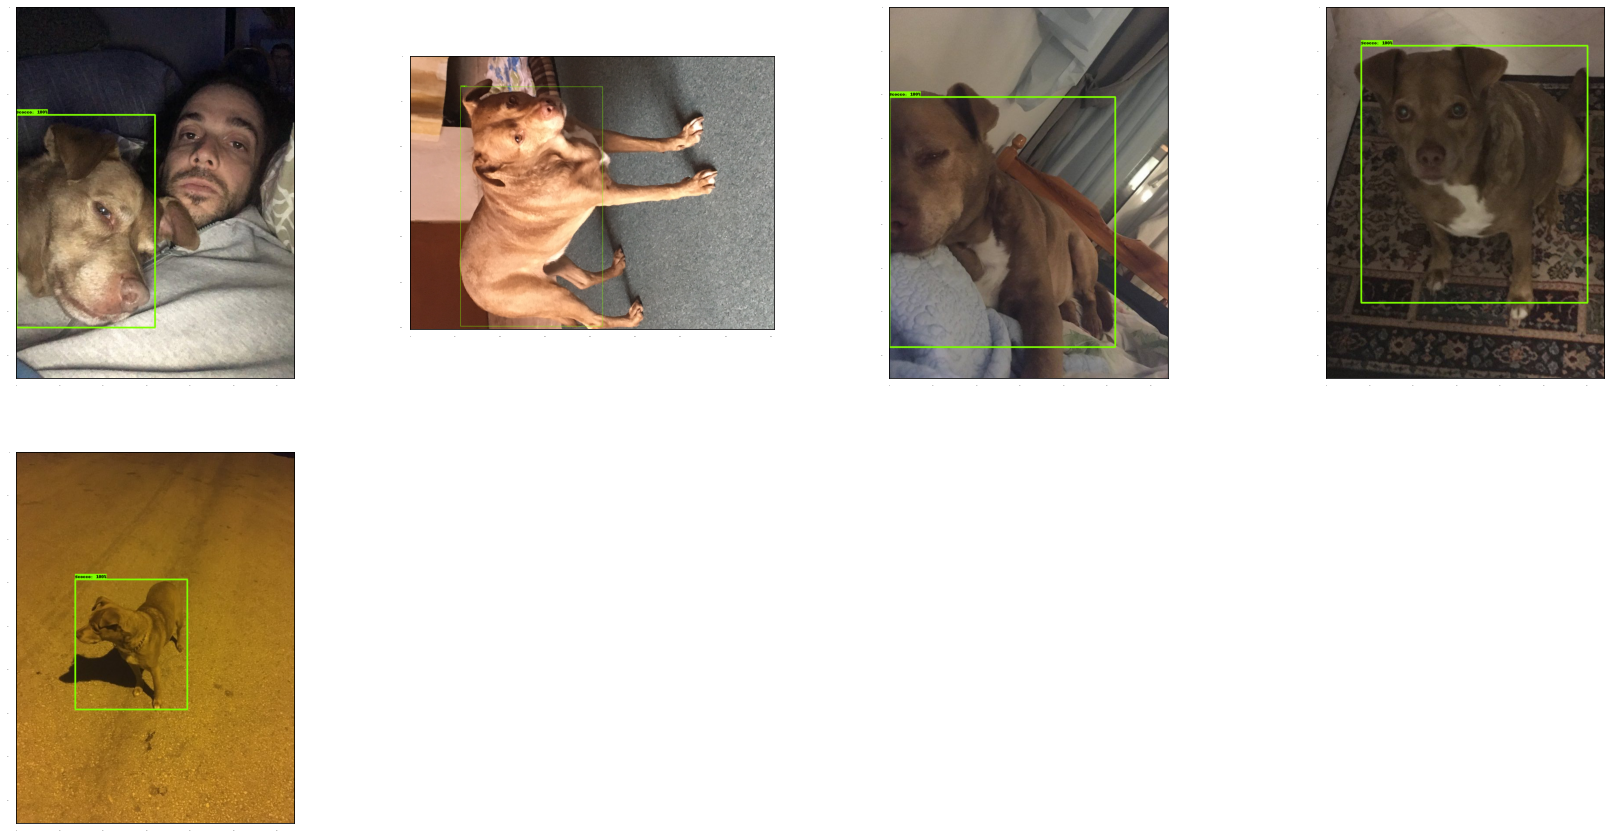

In [12]:
# let's see now all training images with their bounding boxes we created above

# give boxes a score of 100%
dummy_scores = np.array([1.0], dtype=np.float32)

# define the figure size
plt.figure(figsize=(30, 15))

# use the `plot_detections()` utility function to draw the ground truth boxes
for idx in range(5):
    plt.subplot(2, 4, idx+1)
    plot_detections(
      train_images_np[idx],
      gt_boxes[idx],
      np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
      dummy_scores, category_index)

plt.show()

# 3. Model Configuration

Download the model, modify all necessary configurations, restore weights for the desired layers/parts of the model and build the model.

In [13]:
# Download the SSD Resnet 50 version 1, 640x640 checkpoint
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
    
# untar (decompress) the tar file
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz

# copy the checkpoint to the test_data folder models/research/object_detection/test_data/
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

# delete tar file
!rm -rf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz

--2021-04-27 05:05:47--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 64.233.189.128, 2404:6800:4008:c07::80
Connecting to download.tensorflow.org (download.tensorflow.org)|64.233.189.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M  52.0MB/s    in 4.5s    

2021-04-27 05:05:53 (52.0 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’ saved [244817203/244817203]



In [14]:
# configure the model
tf.keras.backend.clear_session()

# define the path to the .config file for ssd resnet 50 v1 640x640
pipeline_config = "/content/models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config"

# Load the configuration file into a dictionary
configs = config_util.get_configs_from_pipeline_file(pipeline_config)

# See what configs looks like
#configs


# Read in the object stored at the key 'model' of the configs dictionary
model_config = configs["model"]

# see what model_config looks like
#model_config

# modify model_config:
# 1.modify the number of classes from its default of 90
model_config.ssd.num_classes = num_classes

# 2.freeze batch normalization
model_config.ssd.freeze_batchnorm = True

# See what model_config now looks like 
model_config

ssd {
  num_classes: 1
  image_resizer {
    fixed_shape_resizer {
      height: 640
      width: 640
    }
  }
  feature_extractor {
    type: "ssd_resnet50_v1_fpn_keras"
    depth_multiplier: 1.0
    min_depth: 16
    conv_hyperparams {
      regularizer {
        l2_regularizer {
          weight: 0.00039999998989515007
        }
      }
      initializer {
        truncated_normal_initializer {
          mean: 0.0
          stddev: 0.029999999329447746
        }
      }
      activation: RELU_6
      batch_norm {
        decay: 0.996999979019165
        scale: true
        epsilon: 0.0010000000474974513
      }
    }
    override_base_feature_extractor_hyperparams: true
    fpn {
      min_level: 3
      max_level: 7
    }
  }
  box_coder {
    faster_rcnn_box_coder {
      y_scale: 10.0
      x_scale: 10.0
      height_scale: 5.0
      width_scale: 5.0
    }
  }
  matcher {
    argmax_matcher {
      matched_threshold: 0.5
      unmatched_threshold: 0.5
      ignore_thresholds: fa

In [15]:
# build the model
detection_model = model_builder.build(
    model_config, is_training= True, add_summaries=True)

print(type(detection_model))

<class 'object_detection.meta_architectures.ssd_meta_arch.SSDMetaArch'>


# 3b. Find and Define checkpoints for the desired layers

The parts of [RetinaNet](https://arxiv.org/abs/1708.02002) we are going to use are a)feature extraction layers and b)bounding box regression prediction layer. We don't want to use the classification prediction layer, since we are going to define our classification layer specific to scocco. So, for the parts of the model we are going to reuse, we need to restore their weights from checkpoints. In the following cell, a detective process is occured in order to find out how we can restore these weights from checkpoints.

In [30]:
# take a look at the type of the detection_model and its Python class
detection_model

In [31]:
# Go to models -> research -> object_detection -> ssd_meta_arch.py(the type of our model) and check model's variables
vars(detection_model)

{'_activity_regularizer': None,
 '_add_background_class': True,
 '_add_summaries': True,
 '_anchor_generator': <object_detection.anchor_generators.multiscale_grid_anchor_generator.MultiscaleGridAnchorGenerator at 0x7f6890e3da90>,
 '_anchors': <object_detection.core.box_list.BoxList at 0x7f688fd99490>,
 '_auto_track_sub_layers': True,
 '_autocast': True,
 '_batched_prediction_tensor_names': ListWrapper(['preprocessed_inputs', 'feature_maps', 'final_anchors', 'box_encodings', 'class_predictions_with_background']),
 '_box_coder': <object_detection.box_coders.faster_rcnn_box_coder.FasterRcnnBoxCoder at 0x7f6890f10290>,
 '_box_predictor': <object_detection.predictors.convolutional_keras_box_predictor.WeightSharedConvolutionalBoxPredictor at 0x7f68905daf10>,
 '_build_input_shape': None,
 '_callable_losses': [],
 '_classification_loss': <object_detection.core.losses.SigmoidFocalClassificationLoss at 0x7f68905878d0>,
 '_classification_loss_weight': 1.0,
 '_compute_dtype_object': tf.float32,
 '

From all the above vars, we are interested to reuse _box_predictor and _feature_extractor.

In [32]:
# check the class type of _box_predictor
detection_model._box_predictor

In [33]:
# go to models -> research -> object_detection -> predictors(convolutional_keras_box_predictor.py) and check this class' variables
vars(detection_model._box_predictor)

{'_activity_regularizer': None,
 '_additional_projection_layers': ListWrapper([ListWrapper([]), ListWrapper([]), ListWrapper([]), ListWrapper([]), ListWrapper([])]),
 '_apply_batch_norm': True,
 '_apply_conv_hyperparams_pointwise': False,
 '_auto_track_sub_layers': True,
 '_autocast': True,
 '_base_tower_layers_for_heads': DictWrapper({'box_encodings': ListWrapper([ListWrapper([<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f689383a810>, <object_detection.core.freezable_batch_norm.FreezableBatchNorm object at 0x7f689609ad50>, <tensorflow.python.keras.layers.core.Lambda object at 0x7f68960ce210>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f689383a610>, <object_detection.core.freezable_batch_norm.FreezableBatchNorm object at 0x7f689609ae90>, <tensorflow.python.keras.layers.core.Lambda object at 0x7f68960cec90>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f689383afd0>, <object_detection.core.freezable_batch_norm.FreezableBatc

From all the above vars here, we are interested in:  

*   _base_tower_layers_for_heads points the layers for the prediction before the final bounding box prediction and the layers for the prediction before the final class prediction
*   _box_prediction_head is a dictionary that points to the layer that predicts the bounding boxes and the layer that predicts the class
*   _prediction_heads points to the set of prediction layers (both for classification and for bounding boxes)


In [34]:
# define checkpoints: for the box_predictor and for the model, which points to this box_predictor and feature extractor
tmp_box_predictor_checkpoint = tf.train.Checkpoint(
  _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
)

# Check the datatype of this checkpoint
type(tmp_box_predictor_checkpoint)

# Check the variables of this checkpoint
vars(tmp_box_predictor_checkpoint)

{'_attached_dependencies': None,
 '_base_tower_layers_for_heads': DictWrapper({'box_encodings': ListWrapper([ListWrapper([<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f689383a810>, <object_detection.core.freezable_batch_norm.FreezableBatchNorm object at 0x7f689609ad50>, <tensorflow.python.keras.layers.core.Lambda object at 0x7f68960ce210>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f689383a610>, <object_detection.core.freezable_batch_norm.FreezableBatchNorm object at 0x7f689609ae90>, <tensorflow.python.keras.layers.core.Lambda object at 0x7f68960cec90>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f689383afd0>, <object_detection.core.freezable_batch_norm.FreezableBatchNorm object at 0x7f689383aed0>, <tensorflow.python.keras.layers.core.Lambda object at 0x7f68960d6750>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f68960ced90>, <object_detection.core.freezable_batch_norm.FreezableBatchNorm object at 0x

In [35]:
# define the tmp_model_checkpoint that points the a)feature extractor and b)the above box predictor checkpoint 
tmp_model_checkpoint = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=tmp_box_predictor_checkpoint)

tmp_model_checkpoint = tf.compat.v2.train.Checkpoint(model=tmp_model_checkpoint)

# Check the datatype of this checkpoint
type(tmp_model_checkpoint)

# Check the vars of this checkpoint
vars(tmp_model_checkpoint)

{'_attached_dependencies': None,
 '_save_assign_op': None,
 '_save_counter': None,
 '_saver': <tensorflow.python.training.tracking.util.TrackableSaver at 0x7f6890501ed0>,
 '_self_name_based_restores': set(),
 '_self_saveable_object_factories': {},
 '_self_setattr_tracking': True,
 '_self_unconditional_checkpoint_dependencies': [TrackableReference(name='model', ref=<tensorflow.python.training.tracking.util.Checkpoint object at 0x7f68905010d0>)],
 '_self_unconditional_deferred_dependencies': {},
 '_self_unconditional_dependency_names': {'model': <tensorflow.python.training.tracking.util.Checkpoint at 0x7f68905010d0>},
 '_self_update_uid': -1,
 'model': <tensorflow.python.training.tracking.util.Checkpoint at 0x7f68905010d0>}

In [36]:
# restore model's checkpoint
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

# Define a checkpoint that sets `model= None
checkpoint = tf.train.Checkpoint(model = detection_model)

# Restore the checkpoint to the checkpoint path
tmp_model_checkpoint.restore(checkpoint_path).expect_partial()


# 3c. Configure the training

Generate model's vars, set training hyperparameters and choose the right layers to fine-tune.

Run a dummy image through the model so that variables are created. We need to select the trainable variables later but now, it is still empty. Try running `len(detection_model.trainable_variables)` in a code cell and you will get `0`. We will pass in a dummy image through the forward pass to create these variables.

Recall that `detection_model` is an object of type [object_detection.meta_architectures.ssd_meta_arch.SSDMetaArch]() 

Important methods that are available in the `detection_model` object  are:
- [preprocess()](https://github.com/tensorflow/models/blob/dc4d11216b738920ddb136729e3ae71bddb75c7e/research/object_detection/meta_architectures/ssd_meta_arch.py#L459): 
    - takes in a tensor representing an image and returns
    - returns `image, shapes`
    - For the dummy image, you can declare a [tensor of zeros](https://www.tensorflow.org/api_docs/python/tf/zeros) that has a shape that the `preprocess()` method can accept (i.e. [batch, height, width, channels]). 
    - Remember that your images have dimensions 640 x 640 x 3. 
    - You can pass in a batch of 1 when making the dummy image. 

- [predict()](https://github.com/tensorflow/models/blob/dc4d11216b738920ddb136729e3ae71bddb75c7e/research/object_detection/meta_architectures/ssd_meta_arch.py#L525)
  - takes in `image, shapes` which are created by the `preprocess()` function call.
  - returns a prediction in a Python dictionary
  - this will pass the dummy image through the forward pass of the network and create the model variables

- [postprocess()](https://github.com/tensorflow/models/blob/dc4d11216b738920ddb136729e3ae71bddb75c7e/research/object_detection/meta_architectures/ssd_meta_arch.py#L655)
  - Takes in the prediction_dict and shapes
  - returns a dictionary of post-processed predictions of detected objects ("detections").
  
  
We use the variable names, which include the prefix `tmp_`, since these variables won't be used later, but you'll define similarly-named variables later for predicting on actual scocco images. 

In [29]:
# use the detection model's `preprocess()` method and pass a dummy image
tmp_image, tmp_shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))

# run a prediction with the preprocessed image and shapes
tmp_prediction_dict = detection_model.predict(tmp_image, tmp_shapes)

# postprocess the predictions into final detections
tmp_detections = detection_model.postprocess(tmp_prediction_dict, tmp_shapes)

### END CODE HERE ###

print('Weights restored!')

# Test Code:
#assert len(detection_model.trainable_variables) > 0, "Please pass in a dummy image to create the trainable variables."

#print(detection_model.weights[0].shape)
#print(detection_model.weights[231].shape)
#print(detection_model.weights[462].shape)

Weights restored!


In [23]:
tf.keras.backend.set_learning_phase(True)

# set training hyperparameters

# set the batch_size
batch_size = 4

# set the number of batches
num_batches = 100

# Set the learning rate
learning_rate = 0.01

# set the optimizer and pass in the learning_rate
optimizer = tf.keras.optimizers.SGD(learning_rate= learning_rate, momentum= 0.9)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [27]:
# now, we need to choose which layers to use

# Inspect the layers of detection_model
for i,v in enumerate(detection_model.trainable_variables):
    print(f"i: {i} \t name: {v.name} \t shape:{v.shape} \t dtype={v.dtype}")

i: 0 	 name: WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/kernel:0 	 shape:(3, 3, 256, 24) 	 dtype=<dtype: 'float32'>
i: 1 	 name: WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/bias:0 	 shape:(24,) 	 dtype=<dtype: 'float32'>
i: 2 	 name: WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead/ClassPredictor/kernel:0 	 shape:(3, 3, 256, 12) 	 dtype=<dtype: 'float32'>
i: 3 	 name: WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead/ClassPredictor/bias:0 	 shape:(12,) 	 dtype=<dtype: 'float32'>
i: 4 	 name: WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_0/kernel:0 	 shape:(3, 3, 256, 256) 	 dtype=<dtype: 'float32'>
i: 5 	 name: WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_0/BatchNorm/feature_0/gamma:0 	 shape:(256,) 	 dtype=<dtype: 'float32'>
i: 6 	 name: WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_0/BatchNorm/feature_0/

In [38]:
# define a list that contains the layers that you wish to fine tune:
# 1.the bounding box head vars, which predict bounding box coordinates
# 2.the class head vars, which predict the class
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

print(to_fine_tune[0].name)
print(to_fine_tune[2].name)

WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/kernel:0
WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead/ClassPredictor/kernel:0


# 4. Train the model

Define the training step and run the training loop.

In the next few following cells, we perform seperately the steps we need for the training step function. You can skip them and go dirctly to the training step function.

In [41]:
# Get a batch of your training images
g_images_list = train_image_tensors[0:2]

# Use .preprocess to preprocess an image so that it can be passed into the model
g_preprocessed_image = detection_model.preprocess(g_images_list[0])
print(f"g_preprocessed_image type: {type(g_preprocessed_image)}")
print(f"g_preprocessed_image length: {len(g_preprocessed_image)}")
print(f"index 0 has the preprocessed image of shape {g_preprocessed_image[0].shape}")
print(f"index 1 has information about the image's true shape excluding padding: {g_preprocessed_image[1]}")

g_preprocessed_image type: <class 'tuple'>
g_preprocessed_image length: 2
index 0 has the preprocessed image of shape (1, 640, 640, 3)
index 1 has information about the image's true shape excluding padding: [[640 640   3]]


In [42]:
# put the outputs of preprocess into 2 lists
preprocessed_image_list = []
true_shape_list = []

for img in g_images_list:
    processed_img, true_shape = detection_model.preprocess(img)
    preprocessed_image_list.append(processed_img)
    true_shape_list.append(true_shape)

#print(f"preprocessed_image_list is of type {type(preprocessed_image_list)}")
#print(f"preprocessed_image_list has length {len(preprocessed_image_list)}")
#print()
#print(f"true_shape_list is of type {type(true_shape_list)}")
#print(f"true_shape_list has length {len(true_shape_list)}")

In [ ]:
# use .predict to make a prediction

# Try to call `predict` and pass in lists; look at the error message
try:
    detection_model.predict(preprocessed_image_list, true_shape_list)
except AttributeError as e:
    print("Error message:", e)

Error message: 'list' object has no attribute 'get_shape'


In [43]:
# look at predict documentation: inputs are expected to be tensors and not list of tensors. Use tf.concat to do it 
# Turn a list of tensors into a tensor
preprocessed_image_tensor = tf.concat(preprocessed_image_list, axis=0)
true_shape_tensor = tf.concat(true_shape_list, axis=0)

print(f"preprocessed_image_tensor shape: {preprocessed_image_tensor.shape}")
print(f"true_shape_tensor shape: {true_shape_tensor.shape}")

preprocessed_image_tensor shape: (2, 640, 640, 3)
true_shape_tensor shape: (2, 3)


In [44]:
# and now, make predictions on the images
prediction_dict = detection_model.predict(preprocessed_image_tensor, true_shape_tensor)

# see what it returns
print("keys in prediction_dict:")
for key in prediction_dict.keys():
    print(key)

keys in prediction_dict:
preprocessed_inputs
feature_maps
anchors
final_anchors
box_encodings
class_predictions_with_background


In [45]:
# after prediction, we need to calculate the loss
# loss takes 2 inputs: predictions and true shapes(ground truth boxes)

try:
    losses_dict = detection_model.loss(prediction_dict, true_shape_tensor)
except RuntimeError as e:
    print(e)

Groundtruth tensor boxes has not been provided


In [46]:
# how to fix this error:
# set the ground truth through provide_groundtruth function with 2 inputs: true boxes and classes

# Get the ground truth bounding boxes
gt_boxes_list = gt_box_tensors[0:2]

# Get the ground truth class labels
gt_classes_list = gt_classes_one_hot_tensors[0:2]

# Provide the ground truth to the model
detection_model.provide_groundtruth(
            groundtruth_boxes_list=gt_boxes_list,
            groundtruth_classes_list=gt_classes_list)

In [47]:
# And now, calculate the loss after providing the ground truth 
losses_dict = detection_model.loss(prediction_dict, true_shape_tensor)

# View the loss dictionary
losses_dict = detection_model.loss(prediction_dict, true_shape_tensor)
print(f"loss dictionary keys: {losses_dict.keys()}")
print(f"localization loss {losses_dict['Loss/localization_loss']:.8f}")
print(f"classification loss {losses_dict['Loss/classification_loss']:.8f}")

# next step is to calculate gradient and optimize the vars which we have selected to fine-tune. We use tf.GradientTape

loss dictionary keys: dict_keys(['Loss/localization_loss', 'Loss/classification_loss'])
localization loss 0.46071038
classification loss 1.12774062


In [48]:
# Let's just reset the model so that you can practice setting it up yourself!
detection_model.provide_groundtruth(groundtruth_boxes_list=[], groundtruth_classes_list=[])

Define the training step:
- Preprocess the images
- Make a prediction
- Calculate the loss (and make sure the loss function has the ground truth to compare with the prediction)
- Calculate the total loss:
  - `total_loss` = `localization_loss + classification_loss`
- Calculate gradients with respect to the variables we selected to train.
- Optimize the model's variables

In [49]:
# decorate with @tf.function for faster training 
@tf.function
def train_step_fn(image_list,
                groundtruth_boxes_list,
                groundtruth_classes_list,
                model,
                optimizer,
                vars_to_fine_tune):
    """A single training iteration.

    Args:
      image_list: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """

    shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)

    with tf.GradientTape() as tape:

        # Preprocess the images      
        preprocessed_image_tensor = tf.concat(
            [detection_model.preprocess(image_tensor)[0]
             for image_tensor in image_list], axis=0)
        true_shape_tensor = preprocessed_image_tensor.shape

        # Make a prediction
        prediction_dict = model.predict(preprocessed_image_tensor, shapes)

        # Calculate the total loss (sum of both losses)
        losses_dict = model.loss(prediction_dict, shapes)
        
        total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']

        # Calculate the gradients
        gradients = tape.gradient(total_loss, vars_to_fine_tune)

        # Optimize the model's selected variables
        optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
        
    return total_loss

Run the training loop using the training step function that we just defined.

In [50]:
print('Start fine-tuning!', flush=True)

for idx in range(num_batches):
    # Grab keys for a random subset of examples
    all_keys = list(range(len(train_images_np)))
    random.shuffle(all_keys)
    example_keys = all_keys[:batch_size]

    # Get the ground truth
    gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
    gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
    
    # get the images
    image_tensors = [train_image_tensors[key] for key in example_keys]

    # Training step (forward pass + backwards pass)
    total_loss = train_step_fn(image_tensors, 
                               gt_boxes_list, 
                               gt_classes_list,
                               detection_model,
                               optimizer,
                               to_fine_tune
                              )

    if idx % 10 == 0:
        print('batch ' + str(idx) + ' of ' + str(num_batches)
        + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

Start fine-tuning!
batch 0 of 100, loss=1.2037928
batch 10 of 100, loss=0.22309382
batch 20 of 100, loss=0.07013338
batch 30 of 100, loss=0.03890686
batch 40 of 100, loss=0.020038553
batch 50 of 100, loss=0.012911903
batch 60 of 100, loss=0.010779643
batch 70 of 100, loss=0.0088284165
batch 80 of 100, loss=0.007925092
batch 90 of 100, loss=0.007533943
Done fine-tuning!


# 5. Run inference on a set of test images

In [51]:
# prepare test images for inference
test_image_dir = './scocco_testing/'
test_images_np = []

# load test images into a numpy array
for i in range(0, 5):
    image_path = os.path.join(test_image_dir, 'scocco-test' + "{0:04}".format(i) + '.jpg')
    print(image_path)
    test_images_np.append(np.expand_dims(
      load_image_into_numpy_array(image_path), axis=0))

./scocco_testing/scocco-test0000.jpg
./scocco_testing/scocco-test0001.jpg
./scocco_testing/scocco-test0002.jpg
./scocco_testing/scocco-test0003.jpg
./scocco_testing/scocco-test0004.jpg


In [52]:
# define detect function: preprocess, detect, postprocess
@tf.function
def detect(input_tensor):
    """Run detection on an input image.

    Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

    Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
    """
    preprocessed_image, shapes = detection_model.preprocess(input_tensor)
    prediction_dict = detection_model.predict(preprocessed_image, shapes)

    # use the detection model's postprocess() method to get the the final detections
    detections = detection_model.postprocess(prediction_dict, shapes)
  
    return detections

In [53]:
# loop through testing images and get scores and bounding boxes overlayed in the original images
!mkdir results

label_id_offset = 1
results = {'boxes': [], 'scores': []}

for i in range(len(test_images_np)):
    # convert test numpy images to tensors
    input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
    # make detections
    detections = detect(input_tensor)
    # plot detections
    plot_detections(
      test_images_np[i][0],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index, figsize=(15, 20), image_name="./results/gif_frame_" + ('%03d' % i) + ".jpg")
    results['boxes'].append(detections['detection_boxes'][0][0].numpy())
    results['scores'].append(detections['detection_scores'][0][0].numpy())

In [56]:
#You can also check if the model detects a scocco class in the images by examining the `scores` key of the `results` dictionary

x = np.array(results['scores'])

# percent of frames where a zombie is detected
scocco_detected = (np.where(x > 0.9, 1, 0).sum())/5*100
print(scocco_detected)

60.0


Frame 0


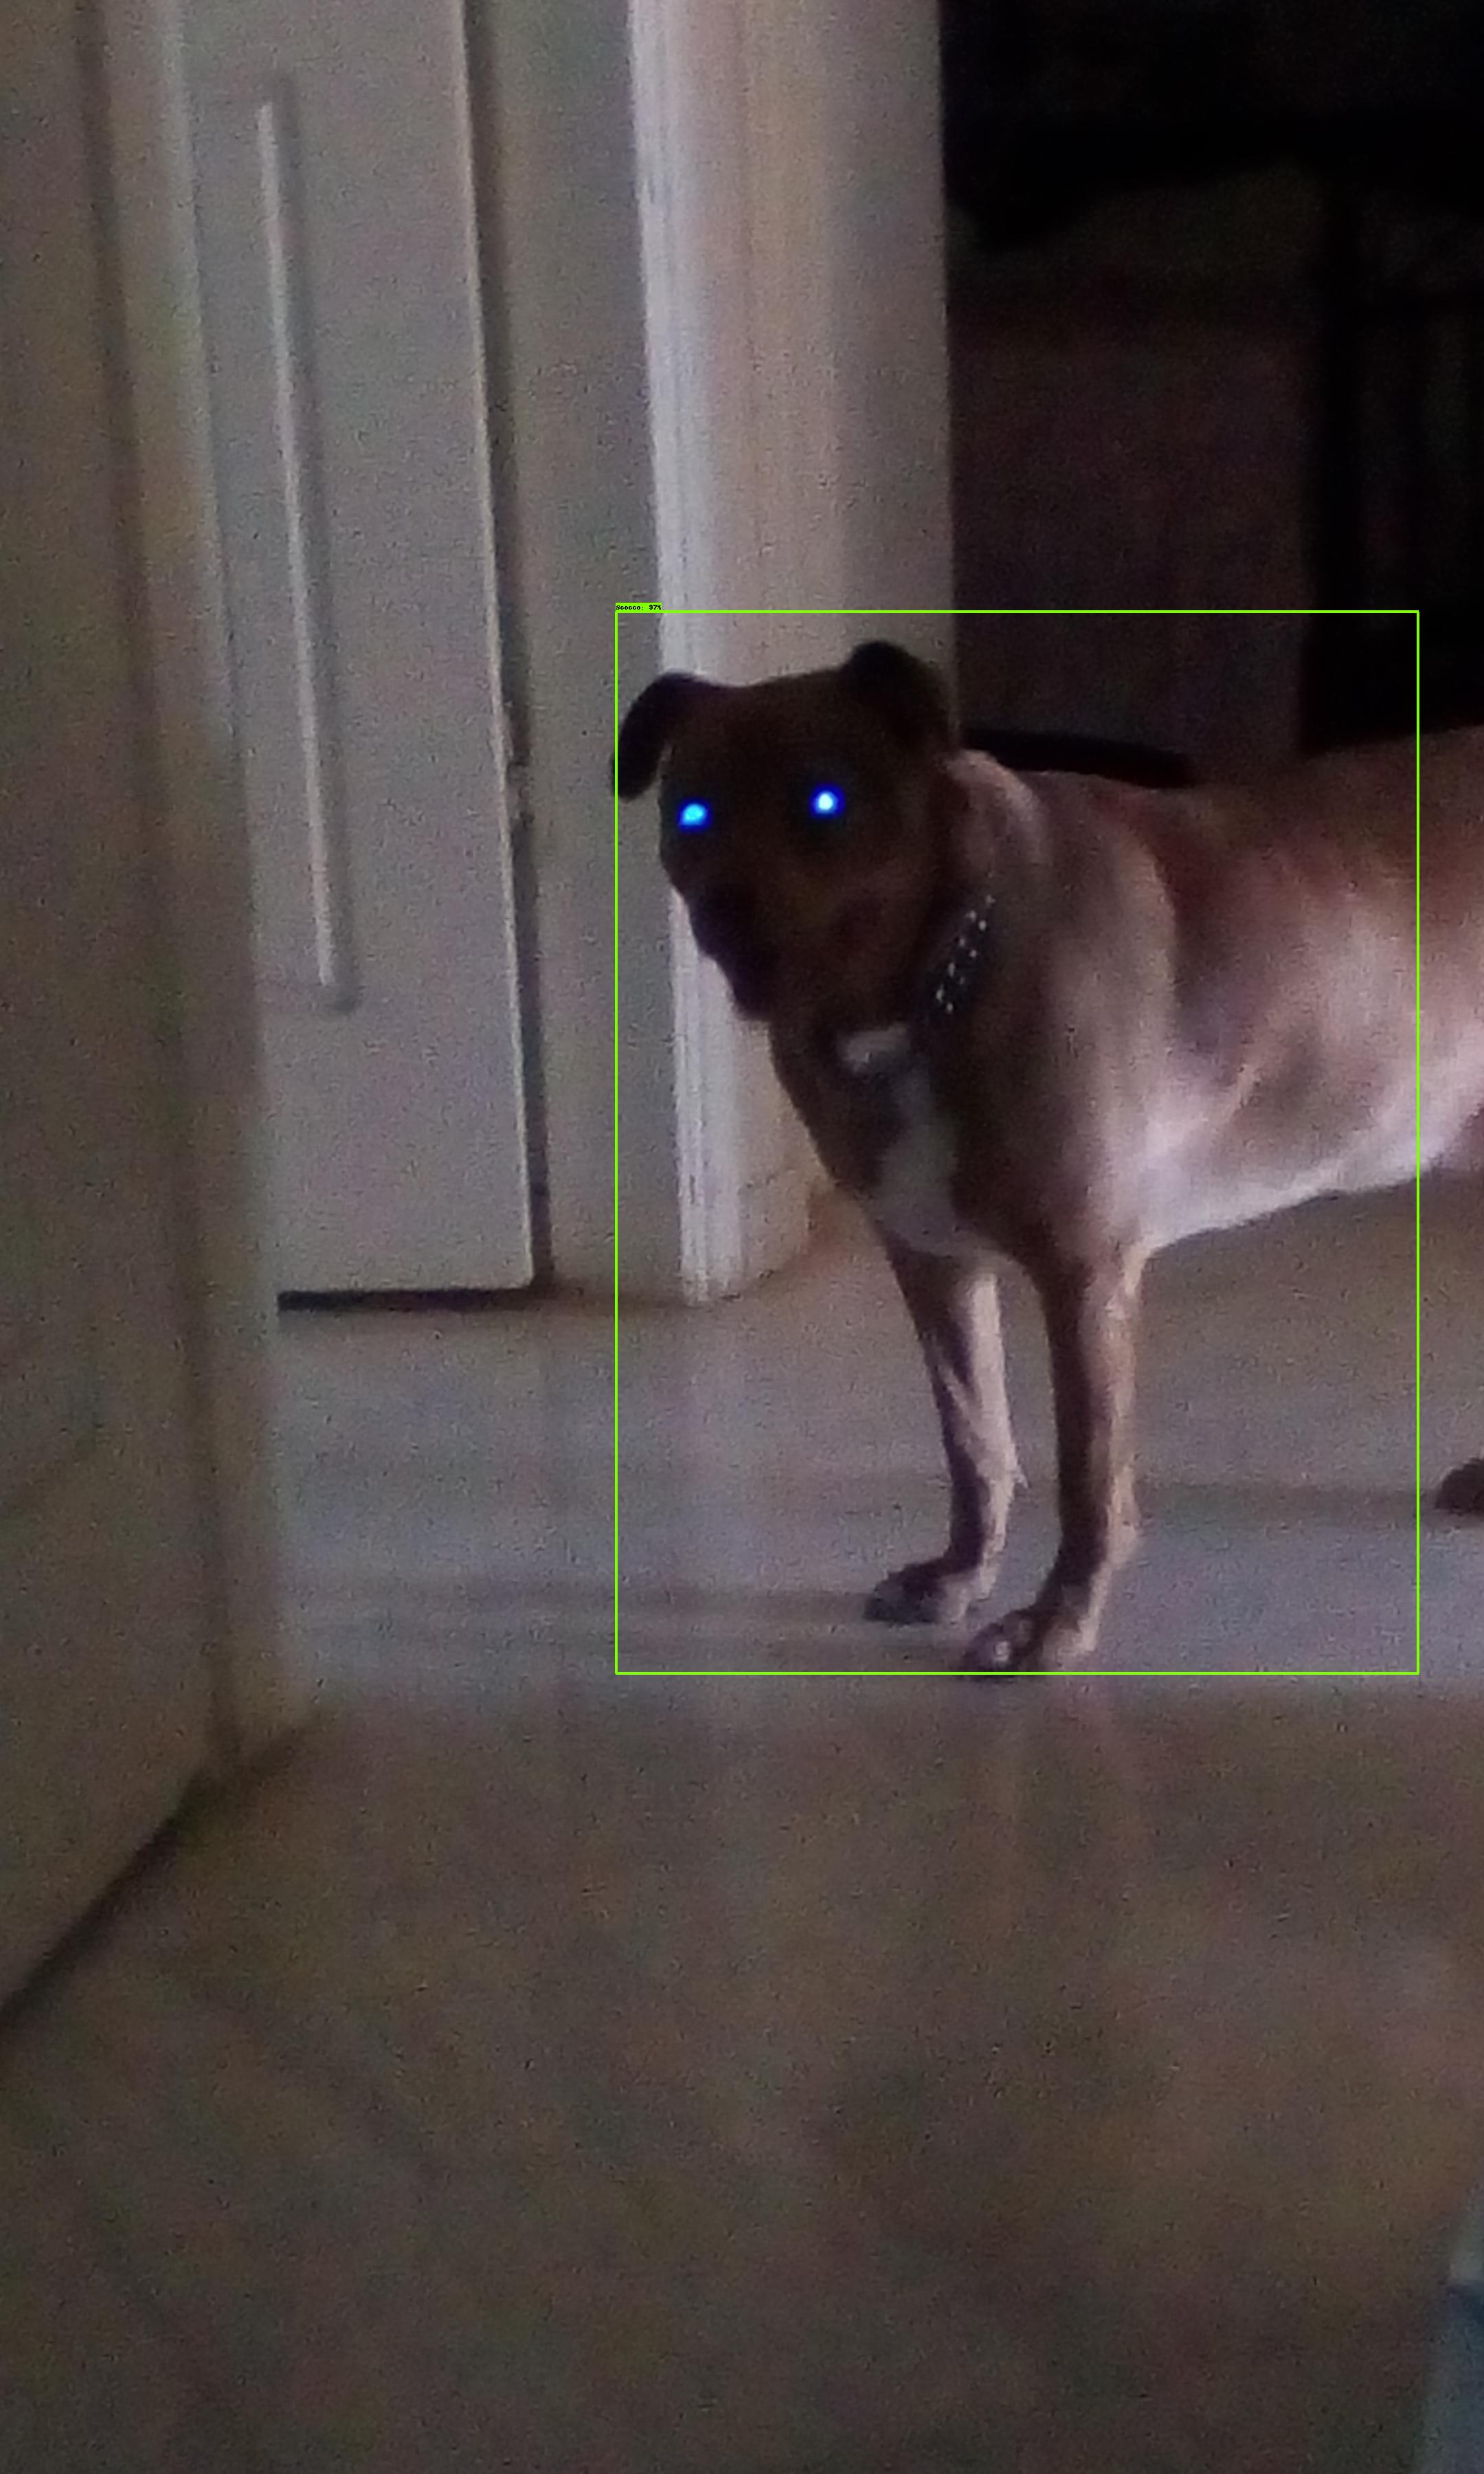


Frame 1


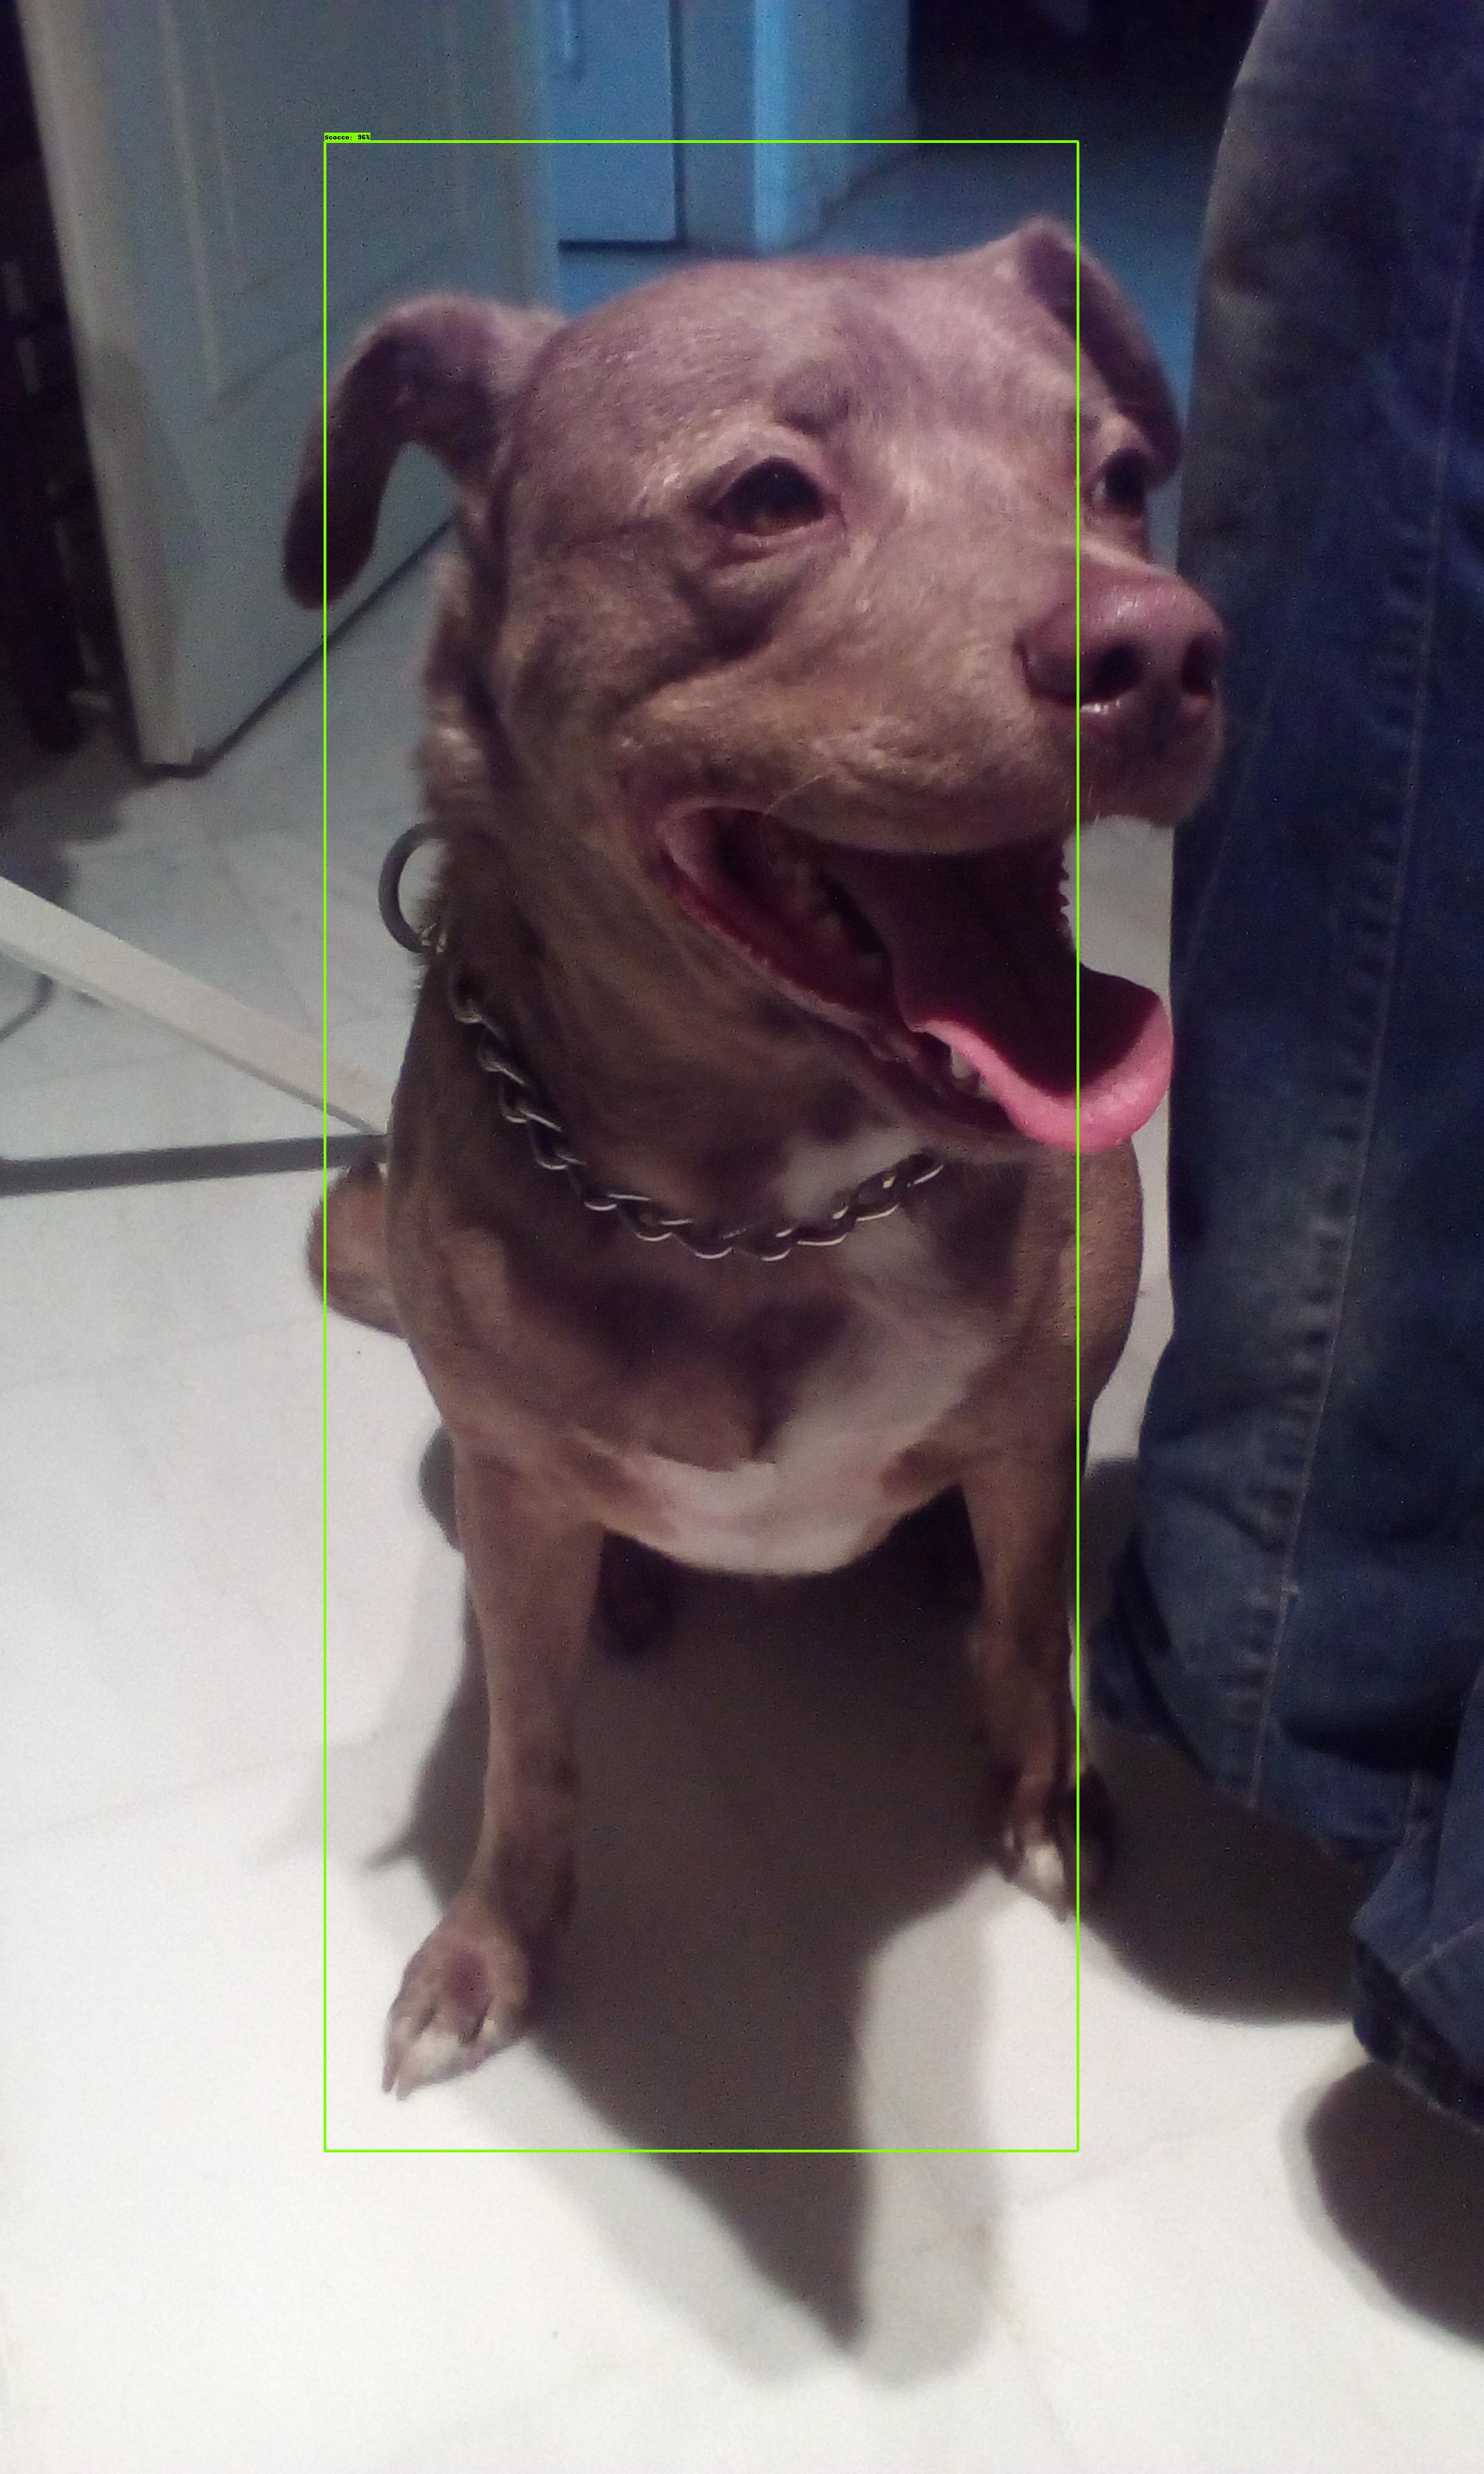


Frame 3


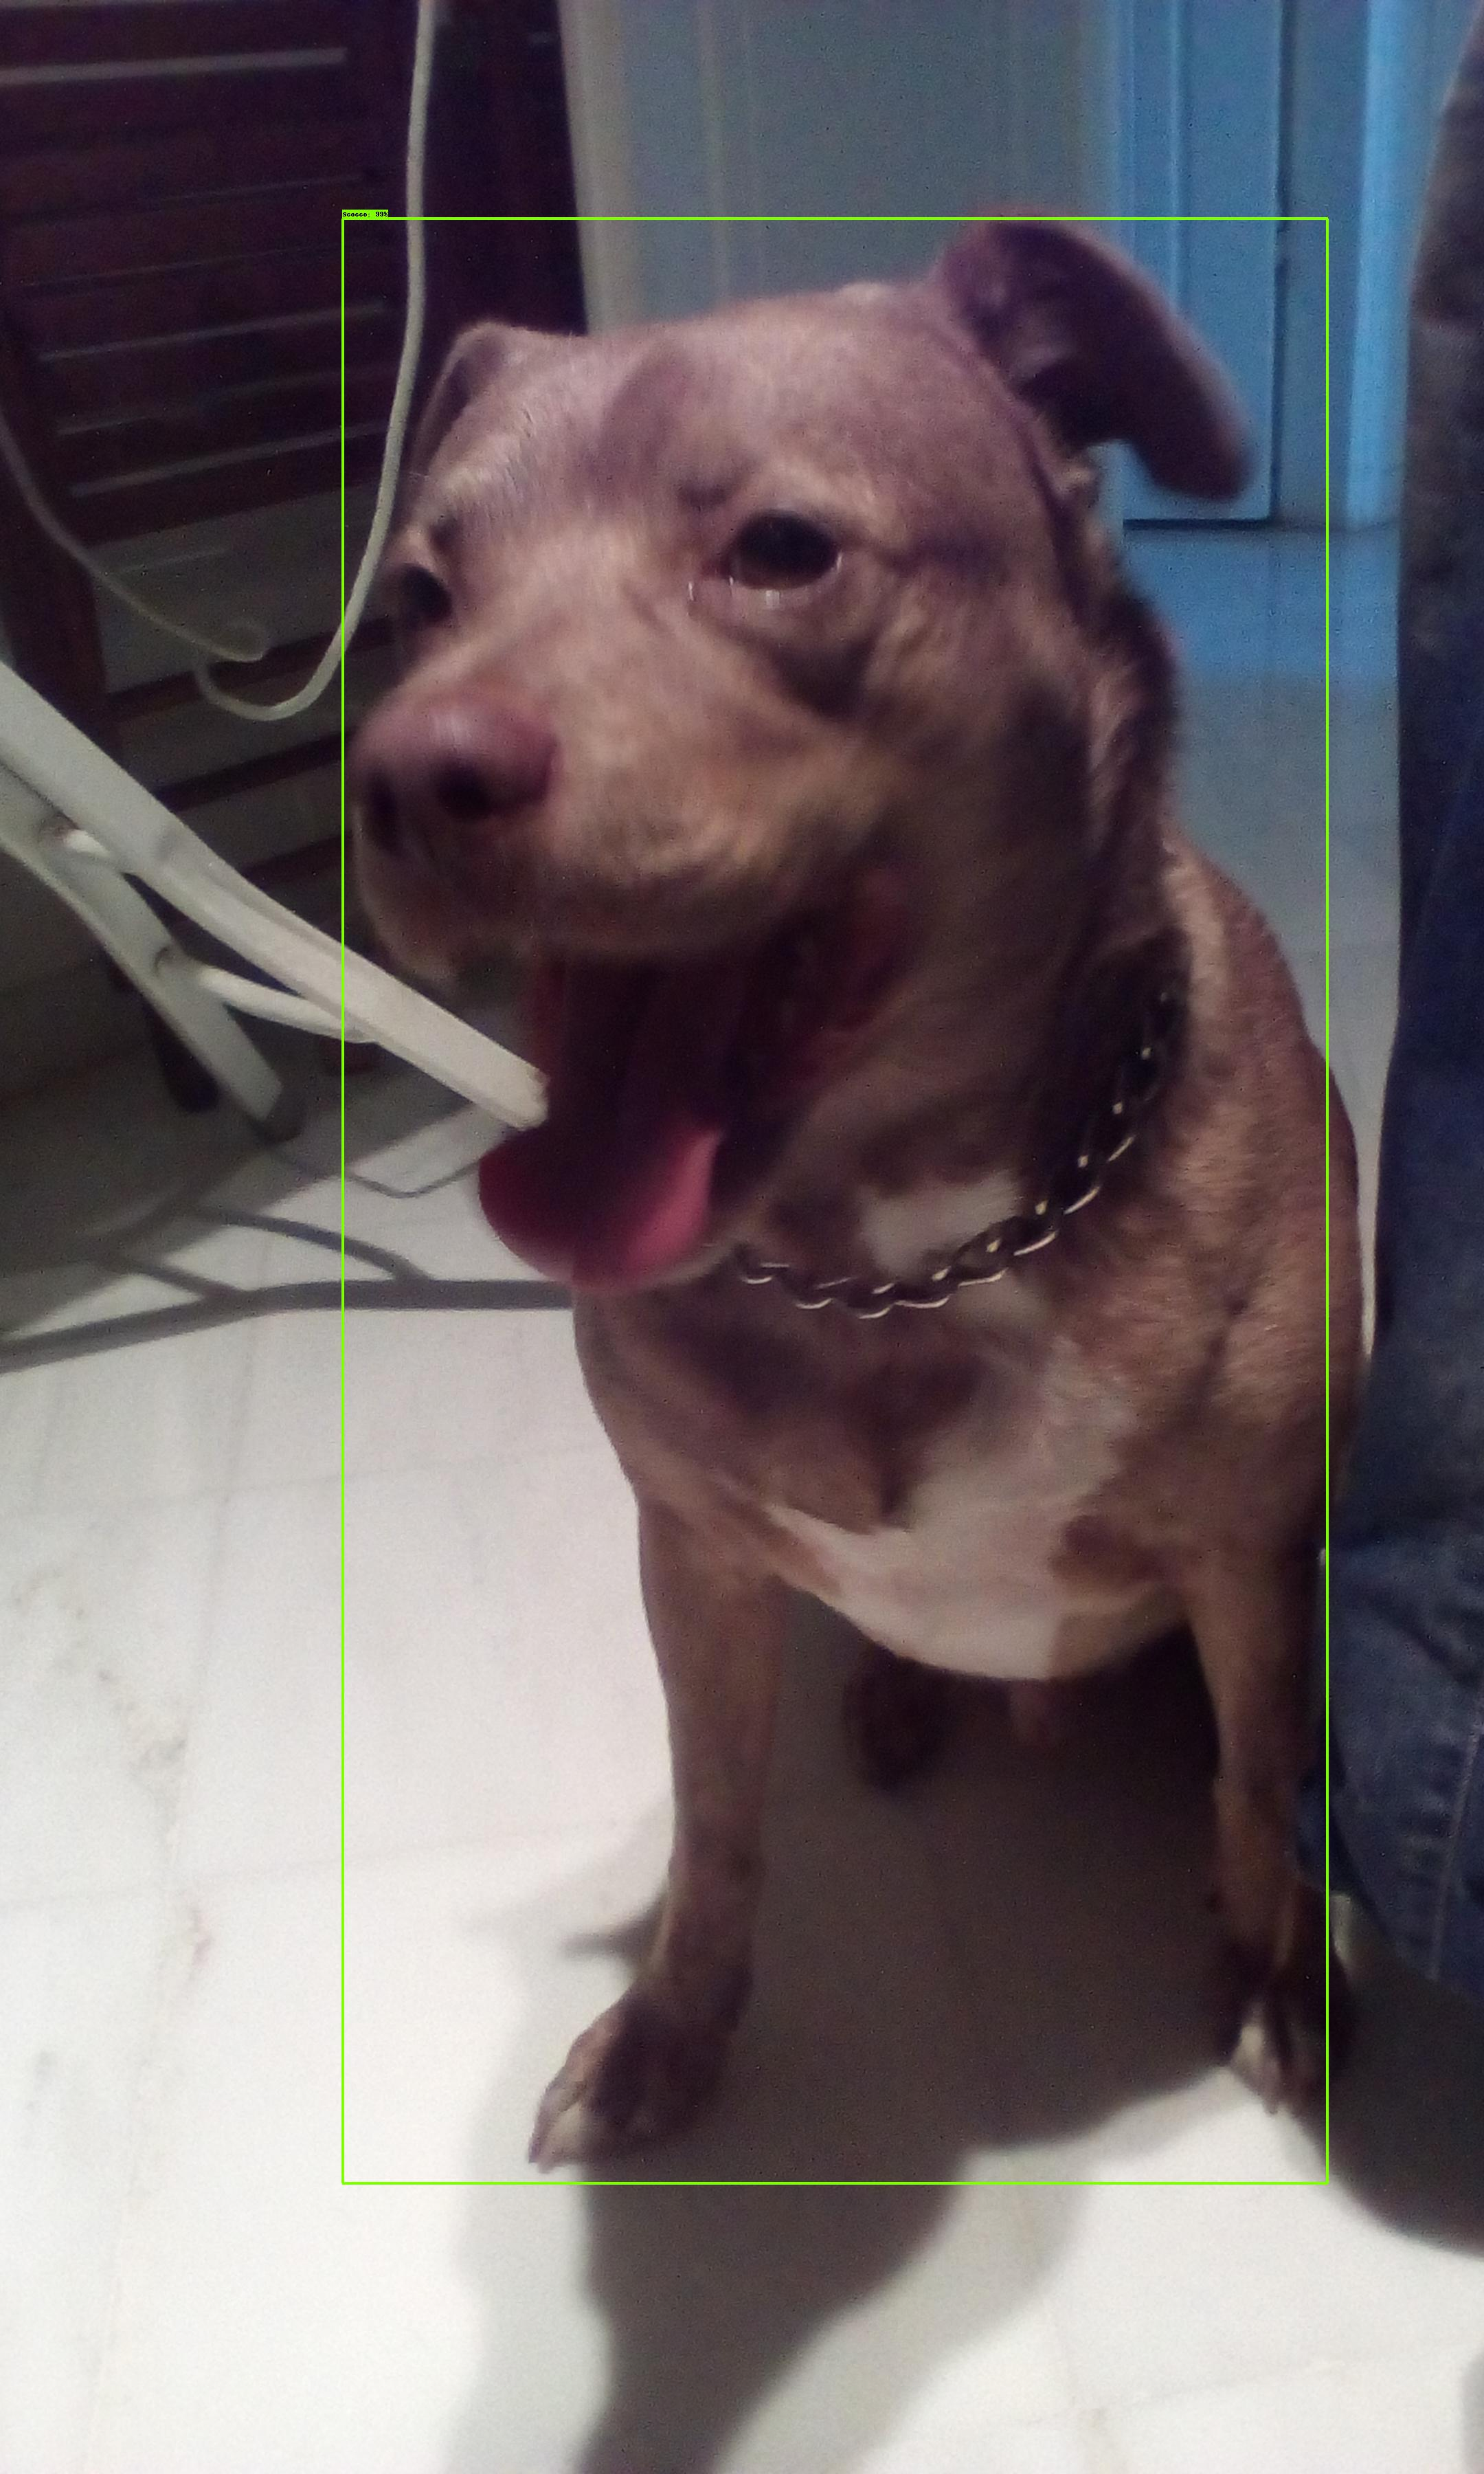

In [58]:
# display some frames. there may be images without bounding box, so re-annotate the training images
print('Frame 0')
display(IPyImage('./results/gif_frame_000.jpg'))
print()
print('Frame 1')
display(IPyImage('./results/gif_frame_001.jpg'))
print()
print('Frame 3')
display(IPyImage('./results/gif_frame_003.jpg'))

# 6. Save results and download

In [62]:
# zip results file

zipf = zipfile.ZipFile('./scocco.zip', 'w', zipfile.ZIP_DEFLATED)

filenames = glob.glob('./results/gif_frame_*.jpg')
filenames = sorted(filenames)

for filename in filenames:
    zipf.write(filename)

zipf.close()


# write results to binary file and download
import pickle

with open('results.data', 'wb') as filehandle:
    pickle.dump(results['boxes'], filehandle)

from google.colab import files
files.download('results.data')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>